# Adaptive distances

It uses a distance between simulations $s$ and observed data $s_\text{obs}$ (or summary statistics representations thereof)

$$d(s, s_\text{obs}) = \left [\sum_{j} \left| w_j ( s_j-s_{\text{obs},j} ) \right|^{p} \right ]^{1/p}$$

with weights $w$ and exponent $p\geq 1$. E.g., $p=2$ gives a weighted Euclidean distance, $p=1$ a Manhattan distance, $p=\inf$ a maximum distance.

## Scale normalization

The concept is based on this seminal work by [Dennis Prangle 2017](https://doi.org/10.1214/16-BA1002):

    Dennis Prangle.
    Adapting the ABC distance function.
    Bayesian Analysis 12.1 (2017): 289-309.

For illustration, we consider a simple Gaussian model:

In [ ]:
# install if not done yet
!pip install pyabc --quiet

In [1]:
import logging
import tempfile

import matplotlib.pyplot as pyplot
import numpy as np

import pyabc

In [2]:
pyabc.settings.set_figure_params("pyabc")  # for beautified plots


# for debugging
df_logger = logging.getLogger("ABC.Distance")
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {
        "s1": p["theta"] + 1 + 0.1 * np.random.normal(),
        "s2": 2 + 10 * np.random.normal(),
    }


# true model parameter
theta_true = 3

# observed summary statistics
observation = {"s1": theta_true + 1, "s2": 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV("uniform", 0, 10))

# database
db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")


def plot_history(history):
    """Plot 1d posteriors over time."""
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=0,
            xmax=10,
            x="theta",
            ax=ax,
            label=f"PDF t={t}",
            refval={"theta": theta_true},
            refval_color="grey",
        )
    ax.legend()

Summary statistic s2 has a high variance compared to summary statistic s1. In addition, s1 is informative about the model parameters $\theta$, s2 is not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled s1 decreases iteratively, while the variability of the sampled s2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of s2, so that convergence can be slowed down. In contrast, if we weight s1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance with uniform weights (i.e. $w\equiv 1$):

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=1, start_time=2021-02-21 17:47:30.131172>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 7.778933103371874
INFO:ABC:t: 0, eps: 7.778933103371874.
INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 4.575936960978553.
INFO:ABC:Acceptance rate: 100 / 362 = 2.7624e-01, ESS=9.7141e+01.
INFO:ABC:t: 2, eps: 2.8701902261289467.
INFO:ABC:Acceptance rate: 100 / 681 = 1.4684e-01, ESS=9.8386e+01.
INFO:ABC:t: 3, eps: 2.023875942258252.
INFO:ABC:Acceptance rate: 100 / 1044 = 9.5785e-02, ESS=9.7783e+01.
INFO:ABC:t: 4, eps: 1.5118440025536204.
INFO:ABC:Acceptance rate: 100 / 1554 = 6.4350e-02, ESS=9.6168e+01.
INFO:ABC:t: 5, eps: 1.1301388952931406.
INFO:ABC:Acceptance rate: 100 / 1981 = 5.0480e-02, ESS=9.9669e+01.
INFO:ABC:t: 6, eps: 0.8387314935260569.
INFO:ABC:Acceptance rate: 100 / 2699 = 3.7051e-02, ESS=9.8505e+01.
INFO:ABC:t: 7, eps: 0.5794568565613941.
INF

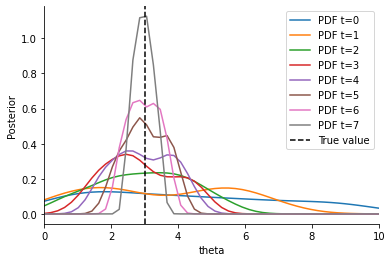

In [3]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)

abc.new(db_path, observation)

h_uni = abc.run(max_nr_populations=7)

plot_history(h_uni)

Second, we consider an adaptive Euclidean distance:

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=2, start_time=2021-02-21 17:47:42.988071>
INFO:ABC:Calibration sample before t=0.
DEBUG:Distance:updated weights[0] = {'ss1': 1.5401324355858197, 'ss2': 0.45986756441418025}
INFO:Epsilon:initial epsilon is 6.402184011500536
INFO:ABC:t: 0, eps: 6.402184011500536.
INFO:ABC:Acceptance rate: 100 / 206 = 4.8544e-01, ESS=1.0000e+02.
DEBUG:Distance:updated weights[1] = {'ss1': 1.5748534021056497, 'ss2': 0.4251465978943503}
INFO:ABC:t: 1, eps: 3.8069208928590106.
INFO:ABC:Acceptance rate: 100 / 266 = 3.7594e-01, ESS=9.9734e+01.
DEBUG:Distance:updated weights[2] = {'ss1': 1.668033194366411, 'ss2': 0.331966805633589}
INFO:ABC:t: 2, eps: 2.5810307500285887.
INFO:ABC:Acceptance rate: 100 / 324 = 3.0864e-01, ESS=9.9563e+01.
DEBUG:Distance:updated weights[3] = {'ss1': 1.7545950176079597, 'ss2': 0.24540498239204045}
INFO:ABC:t: 3, eps: 1.6847120346396376.
INFO:ABC:Acceptance rate: 100 / 355 = 2.8169e-01, ESS=9.5733e+01.

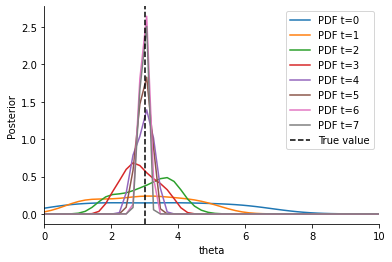

In [4]:
scale_log_file = tempfile.mkstemp(suffix=".json")[1]

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=2,
    scale_function=pyabc.distance.mad,  # method by which to scale
    scale_log_file=scale_log_file,
)

abc = pyabc.ABCSMC(model, prior, distance_adaptive)

abc.new(db_path, observation)

h_ada = abc.run(max_nr_populations=7)

plot_history(h_ada)

In the debug output of `abc.run` above, it can be seen how the weights evolve over time. In the posterior plot, we observe how, compared to the non-adaptive distance, the densitities tend to be narrower around the true parameter $\theta=3$. In addition, despite the better convergence, the required number of samples in total is lower, as can be seen from the below sample numbers plot, as not so much time was wasted trying to match an uninformative summary statistic.

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

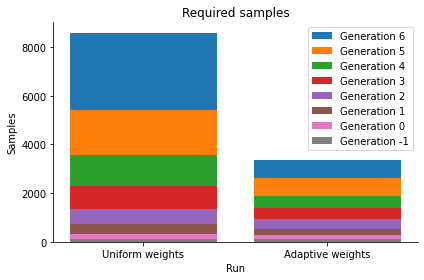

In [5]:
histories = [h_uni, h_ada]
labels = ["Uniform weights", "Adaptive weights"]
pyabc.visualization.plot_sample_numbers(histories, labels)

Indeed, the acceptance rates for the adaptive distance function are consistently higher:

<AxesSubplot:title={'center':'Acceptance rates'}, xlabel='Population index $t$', ylabel='Acceptance rate'>

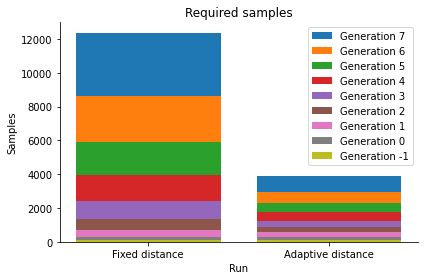

In [6]:
histories = [history0, history1]
labels = ["Fixed distance", "Adaptive distance"]
pyabc.visualization.plot_sample_numbers(histories, labels)

Indeed, the acceptance rates for the adaptive distance function are continually higher:

<AxesSubplot:title={'center':'Acceptance rates'}, xlabel='Population index $t$', ylabel='Acceptance rate'>

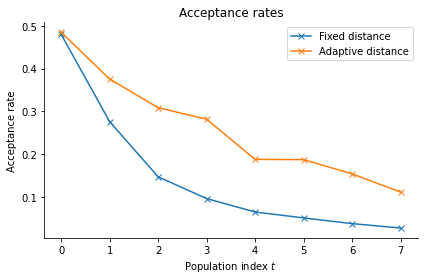

In [6]:
pyabc.visualization.plot_acceptance_rates_trajectory(histories, labels)

The log file stores the weights of each generation, allowing for further analysis. We can see that indeed ss1 is assigned a higher weight than ss2, the ratio increasing over time.

<AxesSubplot:xlabel='Summary statistic', ylabel='Weight'>

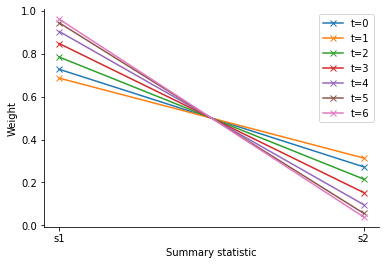

In [7]:
ts = list(range(h_ada.max_t + 1))
labels = [f"t={t}" for t in ts]

pyabc.visualization.plot_distance_weights(
    log_files=scale_log_file,
    ts=ts,
    labels=labels,
)

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a calibration sample from the prior), the method `update()` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via `configure_sampler()`, the distance function tells the sampler to not only record accepted particles, but all that were generated during the sampling process.

Above, the acceptance step uses in each generation only the distance based on the current weights. Sometimes it may be preferable to have nested acceptance regions, by also checking all previous acceptance criteria. This can be realized by passing a `acceptor=pyabc.UniformAcceptor(use_complete_history=True)` to the `ABCSMC` class.

For scale normalization, we used as a measure of sample variability above the median absolute deviation (MAD), a robust alternative to the standard deviation. Other measures are possible and implemented in `pyabc.distance.scale`.

## Robustify against model error

One problem not addressed by the previous adaptive weighting scheme is that if there are outliers in the data, things can go wrong. We informally denote by an outlier a data point corrupted by large errors that cannot be expected under the given experimental setup, already accounting for measurement
noise. To circumvent this, robust methods have been developed that are less sensitive to outliers and can even detect and down-weight such points. The methods presented in the following are based on [this work](https://www.biorxiv.org/content/10.1101/2021.07.29.454327v1):

    Yannik Schaelte, Emad Alamoudi, Jan Hasenauer.
    Robust adaptive distance functions for approximate Bayesian inference on outlier-corrupted data.
    bioRxiv 2021.07.29.454327; doi: https://doi.org/10.1101/2021.07.29.454327.
    
As an example, consider the previous model, but with an additional summary statistic of small variance, whose observation however is an outlier, i.e. a deviant value that cannot be explained under the model. This is a scenario that can typically occur in data where some coordinates hardly depend on the inputs, some may however be subject to errors not accounted for by the model due to e.g. external perturbations, or human errors such as wrong or missing labels. Also other outlier scenarios are possible, for a more extensive discussion see the publication.

In [8]:
import logging
import os
import tempfile

import matplotlib.pyplot as pyplot
import numpy as np

import pyabc.visualization

# for debugging
df_logger = logging.getLogger("Distance")
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {
        "s1": p["theta"] + 1 + 0.1 * np.random.normal(),
        "s2": 2 + 10 * np.random.normal(),
        "s3": 2 + 0.1 * np.random.normal(),
    }


# true model parameter
theta_true = 3

# observed summary statistics
observation = {"s1": theta_true + 1, "s2": 2, "s3": 5}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV("uniform", 0, 10))

# database
db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")


def plot_history(history):
    """Plot 1d posteriors over time."""
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=0,
            xmax=10,
            x="theta",
            ax=ax,
            label=f"PDF t={t}",
            refval={"theta": theta_true},
            refval_color="grey",
        )
    ax.legend()

An distance with uniform weights suffers from the same problems as before.

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=3, start_time=2021-02-21 17:47:50.653668>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 4.203826170900065
INFO:ABC:t: 0, eps: 4.203826170900065.
INFO:ABC:Acceptance rate: 100 / 186 = 5.3763e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 3.1901145692500057.
INFO:ABC:Acceptance rate: 100 / 277 = 3.6101e-01, ESS=9.1453e+01.
INFO:ABC:t: 2, eps: 3.046694798705173.
INFO:ABC:Acceptance rate: 100 / 359 = 2.7855e-01, ESS=6.8762e+01.
INFO:ABC:t: 3, eps: 3.0197713813252647.
INFO:ABC:Acceptance rate: 100 / 544 = 1.8382e-01, ESS=7.7061e+01.
INFO:ABC:t: 4, eps: 3.0058997910115113.
INFO:ABC:Acceptance rate: 100 / 1047 = 9.5511e-02, ESS=9.1196e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC id=3, duration=0:00:02.792366, end_time=2021-02-21 17:47:53.446034>


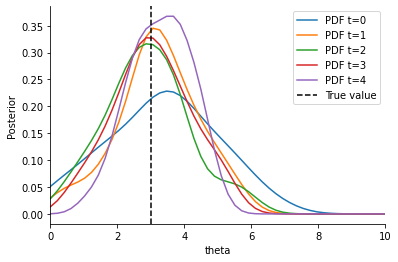

In [9]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(db_path, observation)
h_uni = abc.run(max_nr_populations=7)

plot_history(h_uni)

Next, we consider again a Euclidean distance with adaptive weights.

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=4, start_time=2021-02-21 17:47:53.807857>
INFO:ABC:Calibration sample before t=0.
DEBUG:Distance:updated weights[0] = {'ss1': 0.006075529744069796, 'ss2': 1.9939244702559302}
INFO:Epsilon:initial epsilon is 5.982439965677242
INFO:ABC:t: 0, eps: 5.982439965677242.
INFO:ABC:Acceptance rate: 100 / 191 = 5.2356e-01, ESS=1.0000e+02.
DEBUG:Distance:updated weights[1] = {'ss1': 0.006111889943494511, 'ss2': 1.9938881100565056}
INFO:ABC:t: 1, eps: 5.970558579041115.
INFO:ABC:Acceptance rate: 100 / 304 = 3.2895e-01, ESS=9.4673e+01.
DEBUG:Distance:updated weights[2] = {'ss1': 0.007165118620118855, 'ss2': 1.992834881379881}
INFO:ABC:t: 2, eps: 5.955279657013235.
INFO:ABC:Acceptance rate: 100 / 754 = 1.3263e-01, ESS=9.8384e+01.
DEBUG:Distance:updated weights[3] = {'ss1': 0.007053508636176796, 'ss2': 1.9929464913638233}
INFO:ABC:t: 3, eps: 5.9469779185773985.
INFO:ABC:Acceptance rate: 100 / 2038 = 4.9068e-02, ESS=9.819

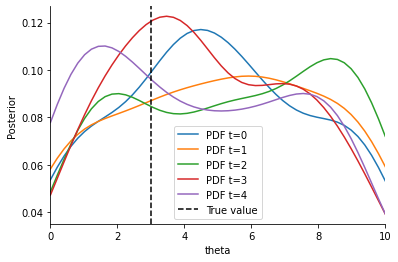

In [10]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2, scale_function=pyabc.distance.std)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.UniformAcceptor(use_complete_history=True))
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.001, max_nr_populations=5)

plot_history(history1)

These results are as expected: The adaptive weights make the situation much worse. Our solution is to firstly use outlier-robust metrics such as a Manhattan distance (p=1), secondly use median absolute deviation instead of standard deviation, and thirdly to in addition to the in-sample variance also take the bias of the samples to the observed data into account, using e.g. `cmad` (combined median absolute deviation to median and observation) as scale function.

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=5, start_time=2021-02-21 17:47:59.078186>
INFO:ABC:Calibration sample before t=0.
DEBUG:Distance:updated weights[0] = {'ss1': 0.8830221978777741, 'ss2': 1.1169778021222259}
INFO:Epsilon:initial epsilon is 4.27887050930462
INFO:ABC:t: 0, eps: 4.27887050930462.
INFO:ABC:Acceptance rate: 100 / 177 = 5.6497e-01, ESS=1.0000e+02.
DEBUG:Distance:updated weights[1] = {'ss1': 0.891045374598389, 'ss2': 1.108954625401611}
INFO:ABC:t: 1, eps: 3.5888140004574542.
INFO:ABC:Acceptance rate: 100 / 199 = 5.0251e-01, ESS=9.8501e+01.
DEBUG:Distance:updated weights[2] = {'ss1': 1.1618030256421565, 'ss2': 0.8381969743578432}
INFO:ABC:t: 2, eps: 2.6570755070696213.
INFO:ABC:Acceptance rate: 100 / 288 = 3.4722e-01, ESS=7.8283e+01.
DEBUG:Distance:updated weights[3] = {'ss1': 1.3317893163806722, 'ss2': 0.6682106836193277}
INFO:ABC:t: 3, eps: 2.059043878773744.
INFO:ABC:Acceptance rate: 100 / 563 = 1.7762e-01, ESS=7.5016e+01.
DEBU

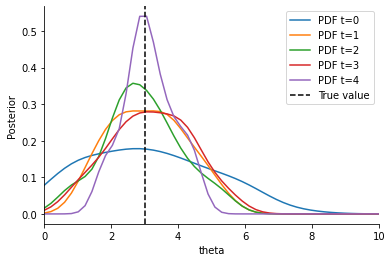

In [10]:
distance_adaptive = pyabc.AdaptivePNormDistance(
    p=2,
    scale_function=pyabc.distance.mad,
)

abc = pyabc.ABCSMC(
    model,
    prior,
    distance_adaptive,
    acceptor=pyabc.UniformAcceptor(use_complete_history=True),
)
abc.new(db_path, observation)
h_ada = abc.run(max_nr_populations=7)

plot_history(h_ada)

These results are as expected: The adaptive weights make the situation much worse, as the impact of the low-variance outlier statistic is increased. Our solution is to firstly use outlier-robust metrics such as a Manhattan distance (p=1), instead of the Euclidean distance used above, which emphasizes large errors.

ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=5, start_time=2022-03-25 17:56:46>
ABC INFO: Calibration sample t = -1.
ABC.Distance DEBUG: Scale weights[0] = {'s1': 3.7101e-01, 's2': 1.7356e-01, 's3': 1.2818e+01}
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 4.06814929e+01.
ABC INFO: Accepted: 100 / 210 = 4.7619e-01, ESS: 1.0000e+02.
ABC.Distance DEBUG: Scale weights[1] = {'s1': 3.6031e-01, 's2': 1.5561e-01, 's3': 1.4466e+01}
ABC INFO: t: 1, eps: 4.41407080e+01.
ABC INFO: Accepted: 100 / 448 = 2.2321e-01, ESS: 8.7540e+01.
ABC.Distance DEBUG: Scale weights[2] = {'s1': 4.3109e-01, 's2': 1.4271e-01, 's3': 1.4640e+01}
ABC INFO: t: 2, eps: 4.42378486e+01.
ABC INFO: Accepted: 100 / 648 = 1.5432e-01, ESS: 9.5623e+01.
ABC.Distance DEBUG: Scale weights[3] = {'s1': 4.9523e-01, 's2': 1.5261e-01, 's3': 1.4854e+01}
ABC INFO: t: 3, eps: 4.42414461e+01.
ABC INFO: Acce

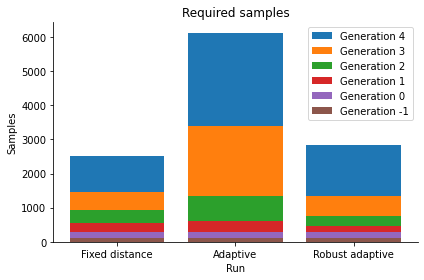

In [11]:
scale_log_file_l1 = tempfile.mkstemp(suffix=".json")[1]

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,  # new, previously p=2
    scale_function=pyabc.distance.mad,
    scale_log_file=scale_log_file_l1,
)

abc = pyabc.ABCSMC(
    model,
    prior,
    distance_adaptive,
    acceptor=pyabc.UniformAcceptor(use_complete_history=True),
)
abc.new(db_path, observation)
h_l1 = abc.run(max_nr_populations=7)

plot_history(h_l1)

This visibly improves the estimates again. However, the outlier statistic still seems to have a considerable impact, as the estimates are considerably worse than without s3. This can be tackled by actively identifying and down-weighting outlier data points, by using a different weighting scheme than MAD. We propose to use the PCMAD (Perhaps-Combined MAD), which either uses MAD, or, if the fraction of severe outliers detected is not too high (precisely not more than 1/3, see the publication and the API for details), uses MAD + MADO, where MADO is the median absolute deviation to the observed value.

ABC.Distance DEBUG: Fit scale ixs: <EventIxs, ts={inf}>
ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=6, start_time=2022-03-25 17:56:55>
ABC INFO: Calibration sample t = -1.
ABC.Distance INFO: Features ['s3'] (ixs=[2]) have a high bias.
ABC.Distance DEBUG: Scale weights[0] = {'s1': 2.0023e-01, 's2': 6.4406e-02, 's3': 3.2667e-01}
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 2.04345057e+00.
ABC INFO: Accepted: 100 / 214 = 4.6729e-01, ESS: 1.0000e+02.
ABC.Distance INFO: Features ['s3'] (ixs=[2]) have a high bias.
ABC.Distance DEBUG: Scale weights[1] = {'s1': 2.0080e-01, 's2': 6.7454e-02, 's3': 3.2413e-01}
ABC INFO: t: 1, eps: 1.64061092e+00.
ABC INFO: Accepted: 100 / 270 = 3.7037e-01, ESS: 9.1801e+01.
ABC.Distance INFO: Features ['s3'] (ixs=[2]) have a high bias.
ABC.Distance DEBUG: Scale weights[2] = {'s1': 3.3611e-01, 's2': 7.4539e-02, 's3': 3.2369e-01}
ABC INFO: t: 2, eps: 1.63893421e+00.
ABC INFO: Accepte

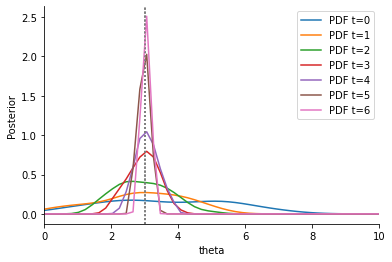

In [12]:
scale_log_file_pcmad = tempfile.mkstemp(suffix=".json")[1]

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,
    scale_function=pyabc.distance.pcmad,  # new, previously mad
    scale_log_file=scale_log_file_pcmad,
)

abc = pyabc.ABCSMC(
    model,
    prior,
    distance_adaptive,
    acceptor=pyabc.UniformAcceptor(use_complete_history=True),
)
abc.new(db_path, observation)
h_pcmad = abc.run(max_nr_populations=7)

plot_history(h_pcmad)

This visibly improves the obtained estimates further. This is due to the respective weights assigned: PCMAD correctly identifies the outlier and assigns a low weight.

<AxesSubplot:xlabel='Summary statistic', ylabel='Weight'>

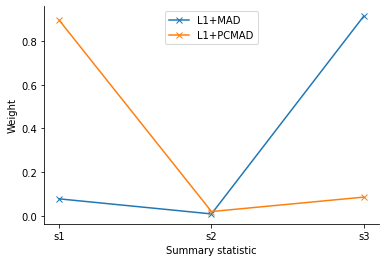

In [13]:
pyabc.visualization.plot_distance_weights(
    [scale_log_file_l1, scale_log_file_pcmad],
    labels=["L1+MAD", "L1+PCMAD"],
)

This result is further obtained with less samples.

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

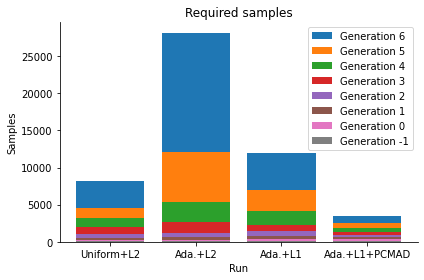

In [14]:
pyabc.visualization.plot_sample_numbers(
    [h_uni, h_ada, h_l1, h_pcmad],
    ["Uniform+L2", "Ada.+L2", "Ada.+L1", "Ada.+L1+PCMAD"],
)

## Conclusion

In general, we recommend the consistent use of an L1 norm over L2, unless squared residuals are needed. This makes the analysis robust to outliers, and further has also shown advantageous on high-dimensional data, where highly deviant points are likely to exist. Further, PCMAD has proven stable and advantageous on multiple test problems, on both outlier-free and outlier-corrupted data. On highly flexible models, it may be unable to reliably detect errors, such that it resorts to MAD. In the implementation in pyABC, PCMAD informs about potential outliers early-on via the logging modules.

## Problems

Thus, what we want to do is add additional "factors" by which we multiply each data point's weight. These factors take into account the number of summary statistics that are equally informative. At the moment, these factors still need to be defined manually.

Let us consider a toy model, where we just copy a single summary statistic N0=100 times. Note that this model is highly artificical, as in practise there might be more information contained in e.g. a time series than in a single measurement, but not N0 times as much, such that a good factor would be somewhere between 1 and N0.

In [14]:
import pyabc
import numpy as np
import os
import tempfile
import matplotlib.pyplot as plt
import logging

# for debugging
df_logger = logging.getLogger("ABC.Distance")
df_logger.setLevel(logging.INFO)

N0 = 100
N1 = 1

p_true = {"p0": 5, "p1": 10}

def model(p):
    ss = {}
    s0 = p["p0"] + 2 * np.random.normal()
    for j in range(N0):
        ss["p0_" + str(j)] = s0
    s1 = p["p1"] + 0.01 * np.random.normal()
    for j in range(N1):
        ss["p1_" + str(j)] = s1
    return ss

prior = pyabc.Distribution(p0=pyabc.RV("uniform", 0, 20),
                           p1=pyabc.RV("uniform", 0, 20))

First, we consider uniform weights of 1:

In [14]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=6)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=6, start_time=2021-02-21 17:48:02.714266>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 856.6062230656909
INFO:ABC:t: 0, eps: 856.6062230656909.
INFO:ABC:Acceptance rate: 100 / 184 = 5.4348e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 348.852031030909.
INFO:ABC:Acceptance rate: 100 / 211 = 4.7393e-01, ESS=9.1059e+01.
INFO:ABC:t: 2, eps: 175.67543494120483.
INFO:ABC:Acceptance rate: 100 / 251 = 3.9841e-01, ESS=7.6837e+01.
INFO:ABC:t: 3, eps: 79.38170833154209.
INFO:ABC:Acceptance rate: 100 / 495 = 2.0202e-01, ESS=8.7866e+01.
INFO:ABC:t: 4, eps: 40.75682284436228.
INFO:ABC:Acceptance rate: 100 / 977 = 1.0235e-01, ESS=8.4025e+01.
INFO:ABC:t: 5, eps: 23.031711037608147.
INFO:ABC:Acceptance rate: 100 / 1961 = 5.0994e-02, ESS=7.0916e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC id=6, duration=0:00:27.806893, end_time=2021-02-21 17:48:30.521159>


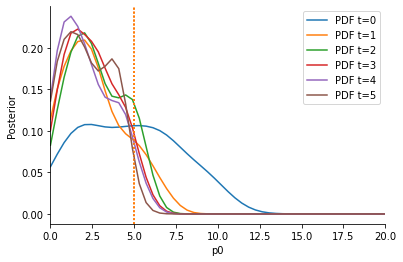

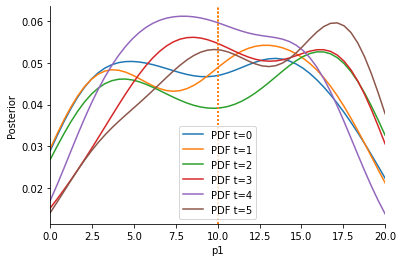

In [15]:
# plotting

def plot_history(history):
    """Plot 1d marginals over time."""
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x="p0", ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x="p1", ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

First, we consider uniform weights of 1:

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=7, start_time=2021-07-31 00:18:44>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 6.47964854e+02.
ABC INFO: Accepted: 100 / 203 = 4.9261e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.30637316e+02.
ABC INFO: Accepted: 100 / 235 = 4.2553e-01, ESS: 9.3357e+01.
ABC INFO: t: 2, eps: 1.24733075e+02.
ABC INFO: Accepted: 100 / 308 = 3.2468e-01, ESS: 8.9111e+01.
ABC INFO: t: 3, eps: 5.75997182e+01.
ABC INFO: Accepted: 100 / 766 = 1.3055e-01, ESS: 7.1882e+01.
ABC INFO: t: 4, eps: 3.20496806e+01.
ABC INFO: Accepted: 100 / 1111 = 9.0009e-02, ESS: 6.7940e+01.
ABC INFO: t: 5, eps: 1.80605147e+01.
ABC INFO: Accepted: 100 / 2841 = 3.5199e-02, ESS: 7.3631e+01.
ABC INFO: t: 6, eps: 1.15602485e+01.
ABC INFO: Accepted: 100 / 5159 = 1.9384e-02, ESS: 6.3477e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=7, duration=0:00:32.321831, end_time=2021-07-31 00:19:17>


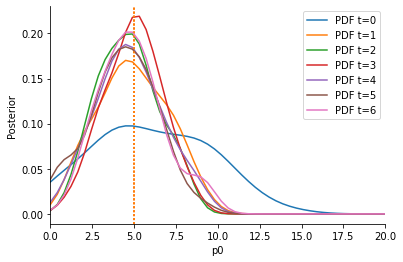

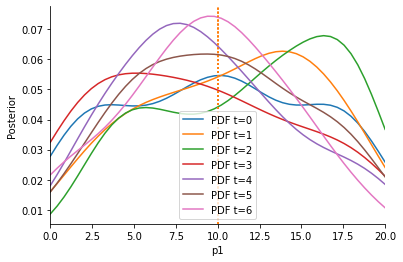

In [15]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=7)

plot_history(history1)

Next, we use adaptive distances but no factors:

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=7, start_time=2021-02-21 17:48:31.794550>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 794.6595092247727
INFO:ABC:t: 0, eps: 794.6595092247727.
INFO:ABC:Acceptance rate: 100 / 203 = 4.9261e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 296.84410935449614.
INFO:ABC:Acceptance rate: 100 / 228 = 4.3860e-01, ESS=8.8446e+01.
INFO:ABC:t: 2, eps: 127.92961359927548.
INFO:ABC:Acceptance rate: 100 / 336 = 2.9762e-01, ESS=8.5924e+01.
INFO:ABC:t: 3, eps: 57.426201893208145.
INFO:ABC:Acceptance rate: 100 / 597 = 1.6750e-01, ESS=7.6977e+01.
INFO:ABC:t: 4, eps: 28.951157829238632.
INFO:ABC:Acceptance rate: 100 / 1120 = 8.9286e-02, ESS=8.3597e+01.
INFO:ABC:t: 5, eps: 14.837885108645287.
INFO:ABC:Acceptance rate: 100 / 2703 = 3.6996e-02, ESS=6.2449e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC id=7, duration=0:00:29.179811, end_time=2021-02-21 17:49:00.974361

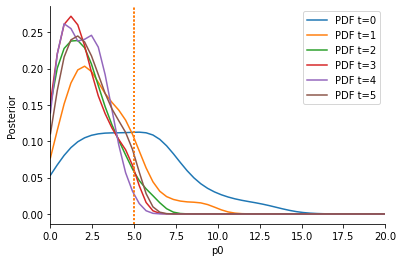

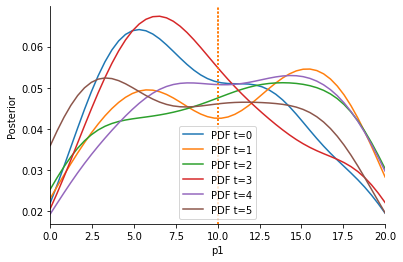

In [16]:
distance = pyabc.AdaptivePNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=6)

plot_history(history2)

Next, we account for the discrepancy in data point counts by using self-defined scaling factors:

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=8, start_time=2021-02-21 17:49:01.953592>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 13.761786897196524
INFO:ABC:t: 0, eps: 13.761786897196524.
INFO:ABC:Acceptance rate: 100 / 208 = 4.8077e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 9.115647882522616.
INFO:ABC:Acceptance rate: 100 / 207 = 4.8309e-01, ESS=9.6277e+01.
INFO:ABC:t: 2, eps: 5.625321191428018.
INFO:ABC:Acceptance rate: 100 / 269 = 3.7175e-01, ESS=8.3290e+01.
INFO:ABC:t: 3, eps: 4.184512004975461.
INFO:ABC:Acceptance rate: 100 / 220 = 4.5455e-01, ESS=7.7520e+01.
INFO:ABC:t: 4, eps: 3.2225506912926334.
INFO:ABC:Acceptance rate: 100 / 293 = 3.4130e-01, ESS=9.3383e+01.
INFO:ABC:t: 5, eps: 1.967803855915238.
INFO:ABC:Acceptance rate: 100 / 397 = 2.5189e-01, ESS=8.6469e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC id=8, duration=0:00:26.305348, end_time=2021-02-21 17:49:28.258940>


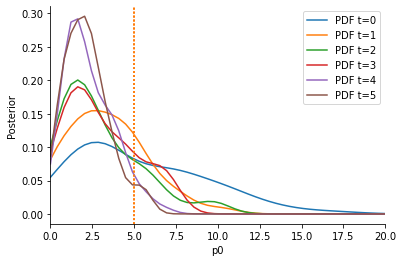

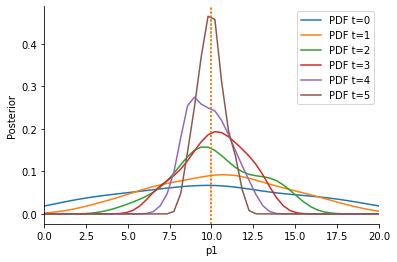

In [17]:
factors = {}
for j in range(N0):
    factors["p0_" + str(j)] = 1/N0
for j in range(N1):
    factors["p1_" + str(j)] = 1/N1
distance = pyabc.PNormDistance(p=1, fixed_weights=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=6)

plot_history(history3)

Next, we consider automatic weighting and factors:

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=9, start_time=2021-02-21 17:49:29.622211>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 13.158767120466832
INFO:ABC:t: 0, eps: 13.158767120466832.
INFO:ABC:Acceptance rate: 100 / 231 = 4.3290e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 8.653521293992382.
INFO:ABC:Acceptance rate: 100 / 217 = 4.6083e-01, ESS=9.5586e+01.
INFO:ABC:t: 2, eps: 5.303200979325762.
INFO:ABC:Acceptance rate: 100 / 277 = 3.6101e-01, ESS=8.3869e+01.
INFO:ABC:t: 3, eps: 3.7377746112716923.
INFO:ABC:Acceptance rate: 100 / 284 = 3.5211e-01, ESS=7.4888e+01.
INFO:ABC:t: 4, eps: 2.6746036201134125.
INFO:ABC:Acceptance rate: 100 / 323 = 3.0960e-01, ESS=8.2144e+01.
INFO:ABC:t: 5, eps: 2.2900147382532334.
INFO:ABC:Acceptance rate: 100 / 303 = 3.3003e-01, ESS=7.4482e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC id=9, duration=0:00:28.345124, end_time=2021-02-21 17:49:57.967335>


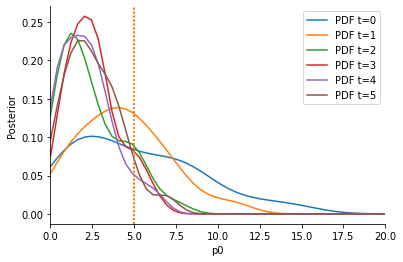

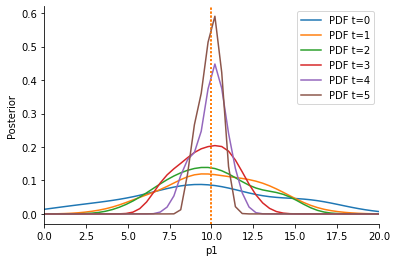

In [18]:
import logging
df_logger = logging.getLogger("ABC.Distance")
# df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors["p0_" + str(j)] = 1/N0
for j in range(N1):
    factors["p1_" + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, fixed_weights=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = pyabc.create_sqlite_db_id(file_="adaptive_distance.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=6)

plot_history(history4)

The results for the distances that re-factor are best, and in this case fixed and adaptive weights give similar results. In addition to the much better posteriors, the sample numbers are much lower, as the below plots show.

<AxesSubplot:title={'center':'Effective sample size'}, xlabel='Population index', ylabel='ESS'>

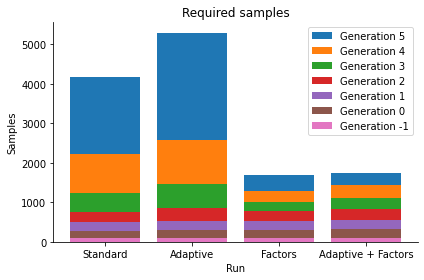

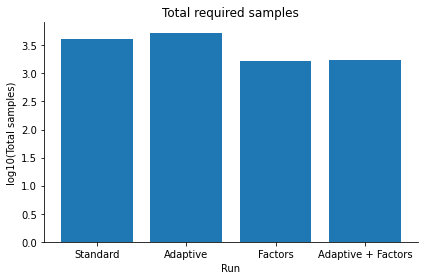

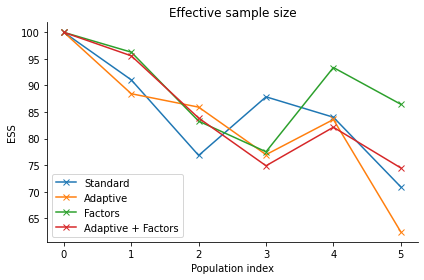

In [19]:
histories = [history1, history2, history3, history4]
labels = ["Standard", "Adaptive", "Factors", "Adaptive + Factors"]

pyabc.visualization.plot_sample_numbers(histories, labels)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale="log10")
pyabc.visualization.plot_effective_sample_sizes(histories, labels)